## Alexnet Architecture Implementation
- Source Literature: [AlexNet Paper](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
- Implemented as per the Specs from the Paper as closely as possible
- The Original Paper Implements the Architecture by splitting it into two parts to train on 2 GPUs simultaneously. 
- The First Version of `Vanilla AlexNet` implementation reflects the original Author's implementation
- The Second Version of `Fused AlexNet` implementation is created as a more optimized version for more modern Single GPU Training. 
- Upon experimentation, the `Vanialla AlexNet` does not effeciently utilize modern GPU hardware. Hence, it has not been used in Model Training.

In [1]:
import os

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import tensorflow as tf

# Vanilla AlexNet Implementation (As per the Original Paper)

In [2]:
# Create AlexNet Model (Vanilla)

# Input Layer
inputs = tf.keras.Input(shape=(224, 224, 3), name="alexnet_input")

# Layer 1 - Convolutions
l1_g1 = tf.keras.layers.Conv2D(filters=48, kernel_size=11, strides=4, padding="same")(inputs)
l1_g1 = tf.keras.layers.BatchNormalization()(l1_g1)
l1_g1 = tf.keras.layers.ReLU()(l1_g1)
l1_g1 = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2)(l1_g1)

l1_g2 = tf.keras.layers.Conv2D(filters=48, kernel_size=11, strides=4, padding="same")(inputs)
l1_g2 = tf.keras.layers.BatchNormalization()(l1_g2)
l1_g2 = tf.keras.layers.ReLU()(l1_g2)
l1_g2 = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2)(l1_g2)

# Layer 2 - Convolutions
l2_g1 = tf.keras.layers.Conv2D(filters=128, kernel_size=5, strides=1, padding="same")(l1_g1)
l2_g1 = tf.keras.layers.BatchNormalization()(l2_g1)
l2_g1 = tf.keras.layers.ReLU()(l2_g1)
l2_g1 = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2)(l2_g1)

l2_g2 = tf.keras.layers.Conv2D(filters=128, kernel_size=5, strides=1, padding="same")(l1_g2)
l2_g2 = tf.keras.layers.BatchNormalization()(l2_g2)
l2_g2 = tf.keras.layers.ReLU()(l2_g2)
l2_g2 = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2)(l2_g2)

# Layer 3 - Convolutions
l3_concat = tf.keras.layers.concatenate([l2_g1, l2_g2], axis=-1)

l3_g1 = tf.keras.layers.Conv2D(filters=192, kernel_size=3, strides=1, padding="same")(l3_concat)
l3_g1 = tf.keras.layers.ReLU()(l3_g1)

l3_g2 = tf.keras.layers.Conv2D(filters=192, kernel_size=3, strides=1, padding="same")(l3_concat)
l3_g2 = tf.keras.layers.ReLU()(l3_g2)

# Layer 4 - Convolutions
l4_g1 = tf.keras.layers.Conv2D(filters=192, kernel_size=3, strides=1, padding="same")(l3_g1)
l4_g1 = tf.keras.layers.ReLU()(l4_g1)

l4_g2 = tf.keras.layers.Conv2D(filters=192, kernel_size=3, strides=1, padding="same")(l3_g2)
l4_g2 = tf.keras.layers.ReLU()(l4_g2)

# Layer 5 - Convolutions
l5_g1 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same")(l4_g1)
l5_g1 = tf.keras.layers.ReLU()(l5_g1)
l5_g1 = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2)(l5_g1)

l5_g2 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same")(l4_g2)
l5_g2 = tf.keras.layers.ReLU()(l5_g2)
l5_g2 = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2)(l5_g2)

# Layer 6 - Dense
l6_pre = tf.keras.layers.concatenate([l5_g1, l5_g2], axis=-1)
l6_pre = tf.keras.layers.Flatten()(l6_pre)

l6 = tf.keras.layers.Dense(units=4096)(l6_pre)
l6 = tf.keras.layers.ReLU()(l6)
l6 = tf.keras.layers.Dropout(rate=0.5)(l6)

# Layer 7 - Dense
l7 = tf.keras.layers.Dense(units=4096)(l6)
l7 = tf.keras.layers.ReLU()(l7)
l7 = tf.keras.layers.Dropout(rate=0.5)(l7)

# Layer 8 - Dense
l8 = tf.keras.layers.Dense(units=1000)(l7)
l8 = tf.keras.layers.Softmax(dtype=tf.float32, name="alexnet_output")(l8)

alexnet = tf.keras.models.Model(inputs=inputs, outputs=l8)

In [3]:
alexnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
alexnet_input (InputLayer)      [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 56, 56, 48)   17472       alexnet_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 56, 56, 48)   17472       alexnet_input[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 56, 56, 48)   192         conv2d[0][0]                     
______________________________________________________________________________________________

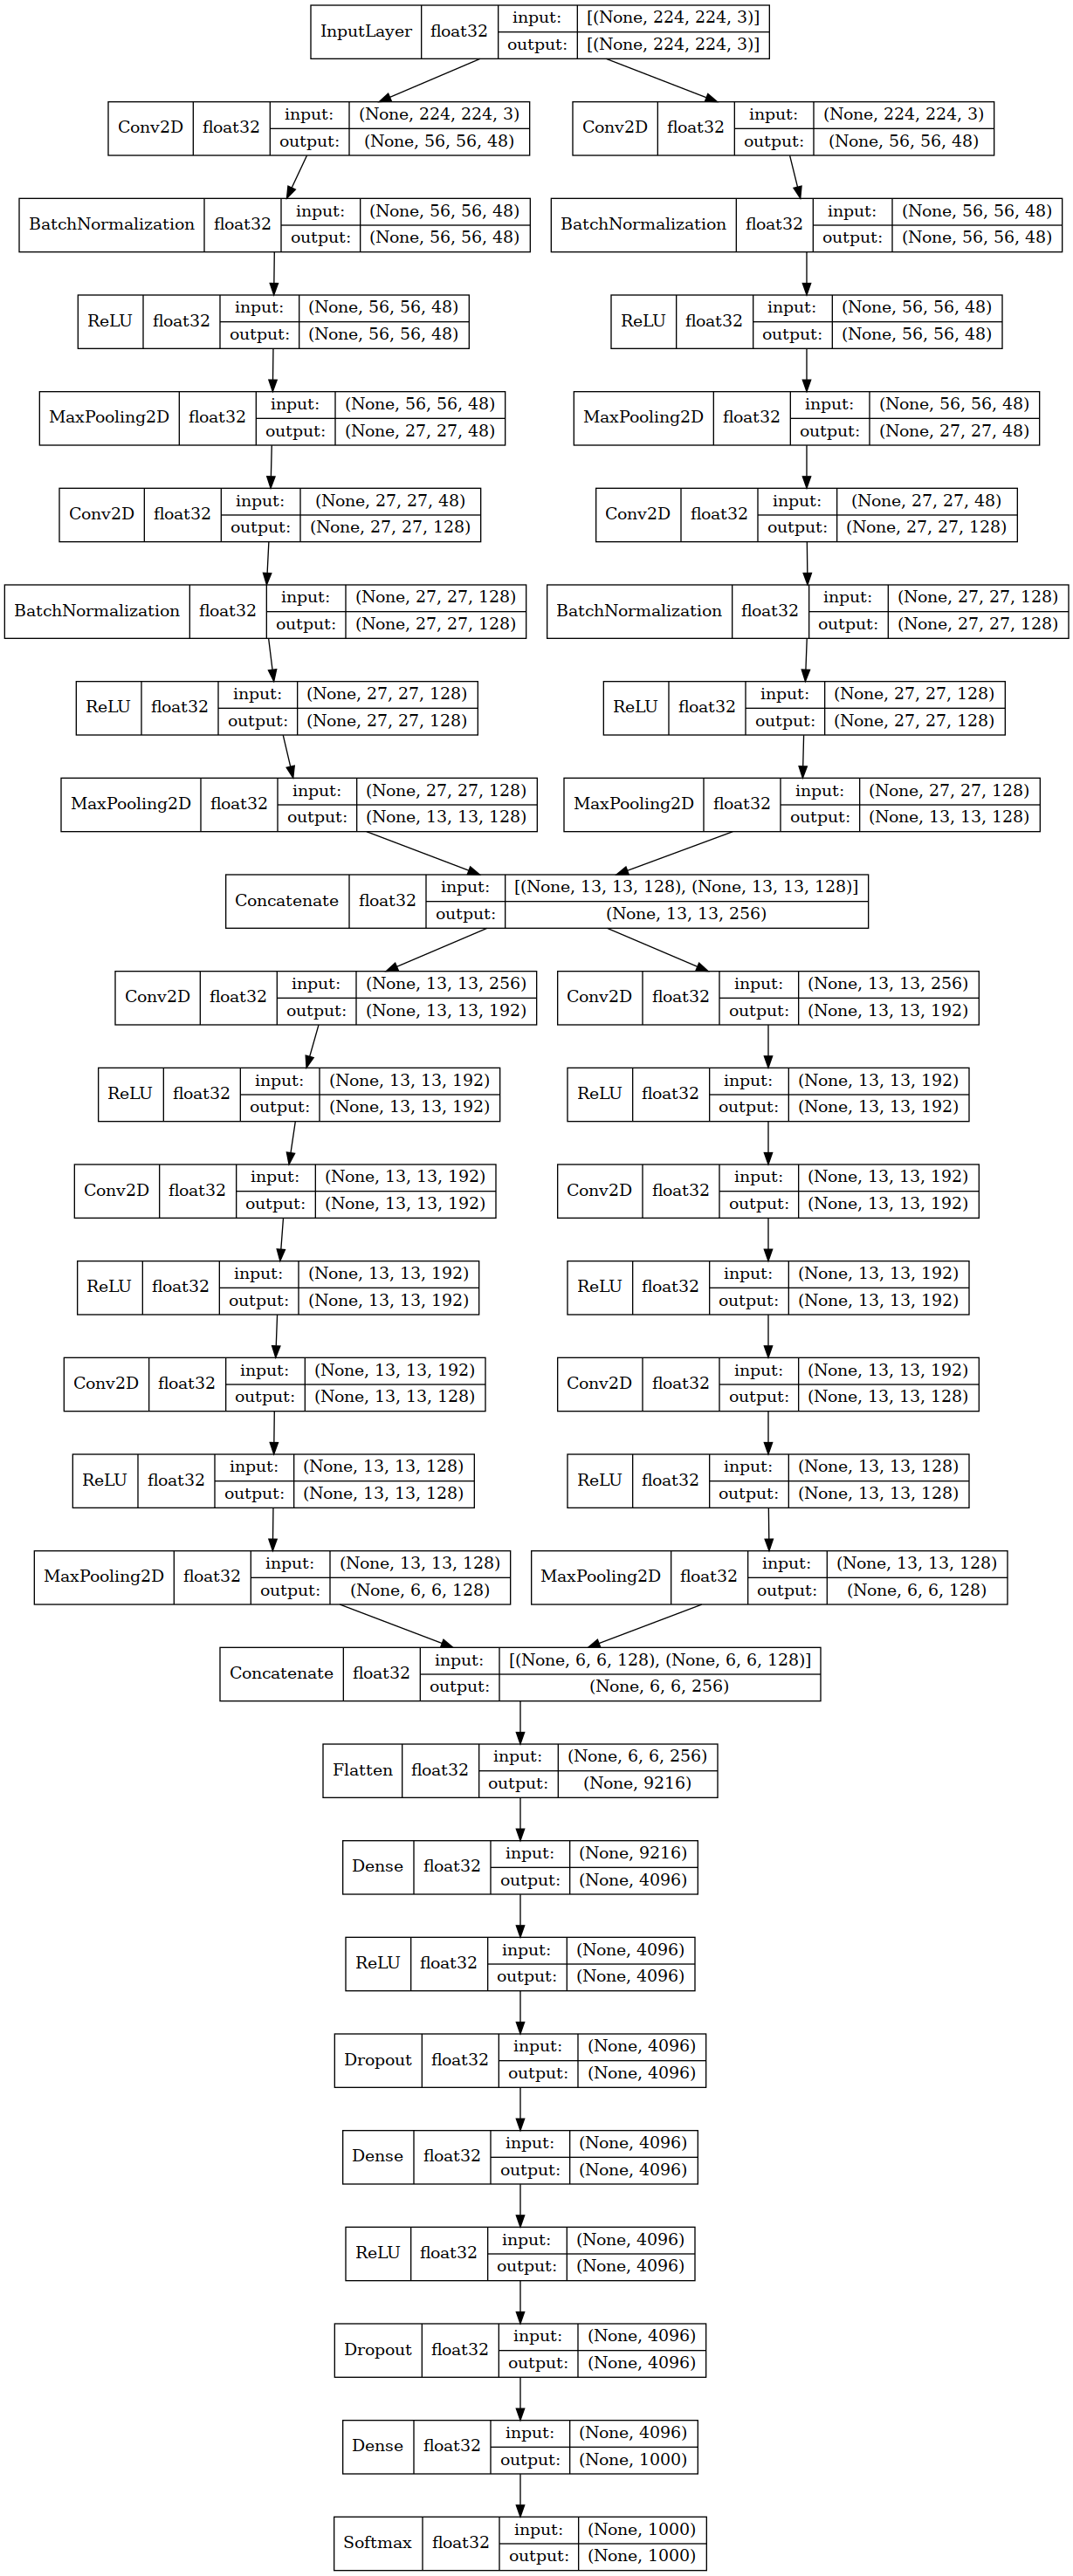

In [4]:
tf.keras.utils.plot_model(alexnet, show_layer_names=False, show_shapes=True, show_dtype=True)

# Fused AlexNet Implementation (Optimized for Modern GPU Training)

In [5]:
# Create AlexNet Model (Fused)

# Input Layer
inputs = tf.keras.Input(shape=(224, 224, 3), name="alexnet_input")

# Layer 1 - Convolutions
l1 = tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4, padding="same")(inputs)
l1 = tf.keras.layers.BatchNormalization()(l1)
l1 = tf.keras.layers.ReLU()(l1)
l1 = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2)(l1)

# Layer 2 - Convolutions
l2 = tf.keras.layers.Conv2D(filters=256, kernel_size=5, strides=1, padding="same")(l1)
l2 = tf.keras.layers.BatchNormalization()(l2)
l2 = tf.keras.layers.ReLU()(l2)
l2 = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2)(l2)

# Layer 3 - Convolutions
l3 = tf.keras.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding="same")(l2)
l3 = tf.keras.layers.ReLU()(l3)

# Layer 4 - Convolutions
l4 = tf.keras.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding="same")(l3)
l4 = tf.keras.layers.ReLU()(l4)

# Layer 5 - Convolutions
l5 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding="same")(l4)
l5 = tf.keras.layers.ReLU()(l5)
l5 = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2)(l5)

# Layer 6 - Dense
l6_pre = tf.keras.layers.Flatten()(l5)

l6 = tf.keras.layers.Dense(units=4096)(l6_pre)
l6 = tf.keras.layers.ReLU()(l6)
l6 = tf.keras.layers.Dropout(rate=0.5)(l6)

# Layer 7 - Dense
l7 = tf.keras.layers.Dense(units=4096)(l6)
l7 = tf.keras.layers.ReLU()(l7)
l7 = tf.keras.layers.Dropout(rate=0.5)(l7)

# Layer 8 - Dense
l8 = tf.keras.layers.Dense(units=1000)(l7)
l8 = tf.keras.layers.Softmax(dtype=tf.float32, name="alexnet_output")(l8)

alexnet = tf.keras.models.Model(inputs=inputs, outputs=l8)

In [6]:
alexnet.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
alexnet_input (InputLayer)   [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 56, 56, 96)        34944     
_________________________________________________________________
batch_normalization_4 (Batch (None, 56, 56, 96)        384       
_________________________________________________________________
re_lu_12 (ReLU)              (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_5 (Batch (None, 27, 27, 256)       1024

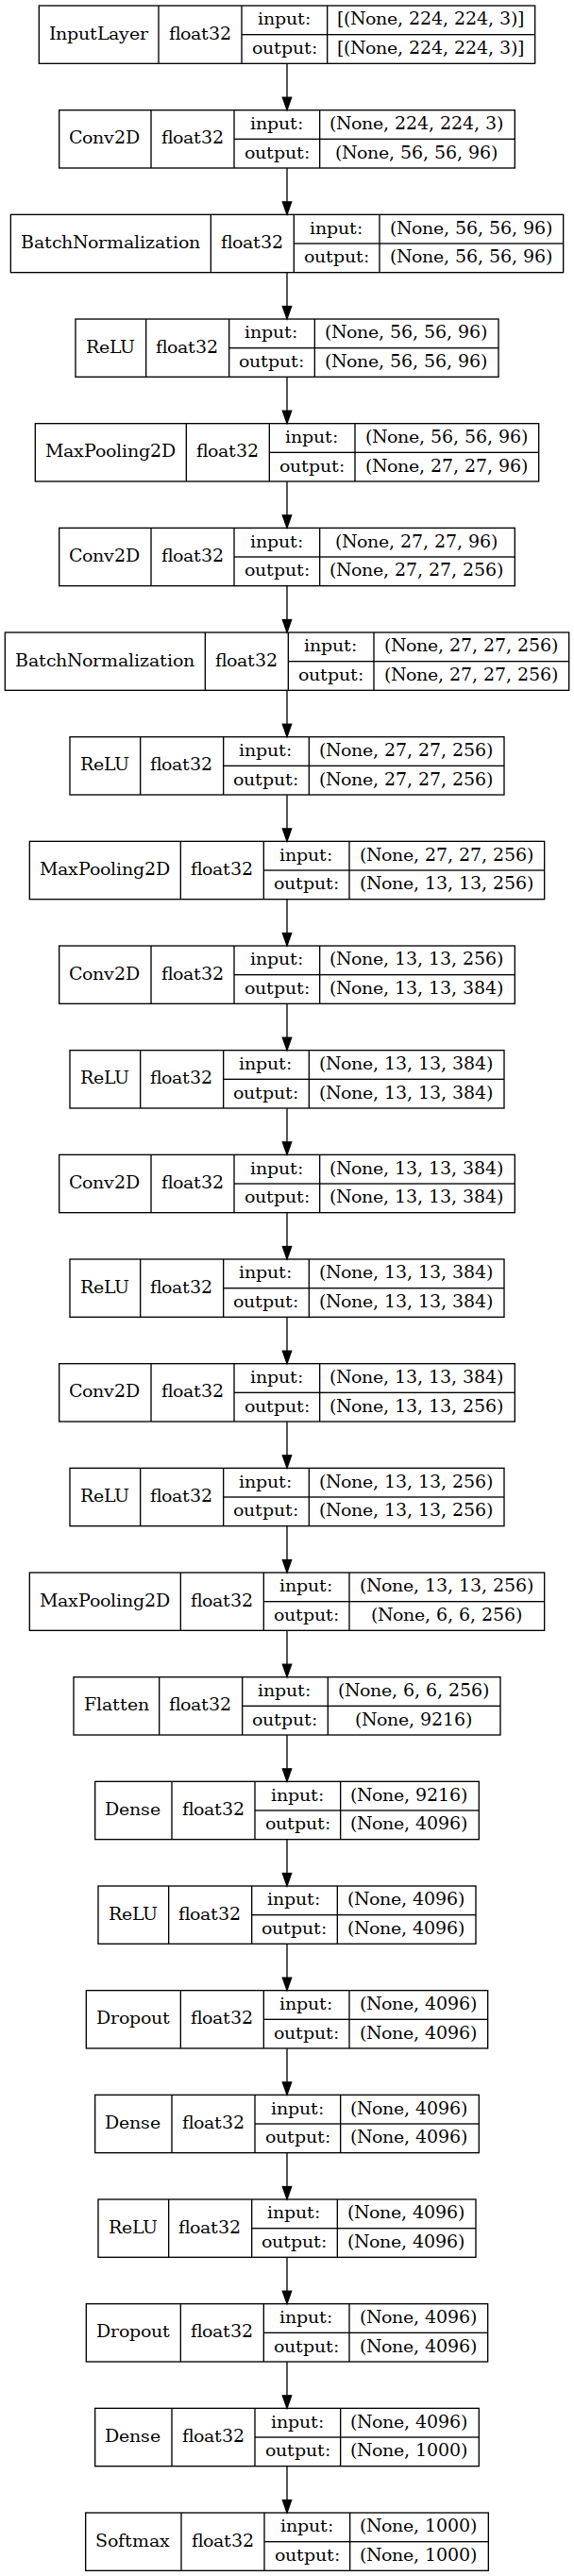

In [7]:
tf.keras.utils.plot_model(alexnet, show_layer_names=False, show_shapes=True, show_dtype=True)